In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [63]:
import numpy,datasets,transformers,torch,torchaudio,accelerate,peft,soundfile

# print("speechbrain:", speechbrain.__version__)
print("Transformers:", transformers.__version__)
print("Datasets:", datasets.__version__)
print("numpy:", np.__version__)
print("Torch:", torch.__version__)
print("torchaudio:", torchaudio.__version__)
print("soundfile:", soundfile.__version__)
print("accelerate:", accelerate.__version__)
print("peft:", peft.__version__)

Transformers: 4.57.1
Datasets: 2.17.1
numpy: 1.26.4
Torch: 2.7.1+cu118
torchaudio: 2.7.1+cu118
soundfile: 0.13.1
accelerate: 1.11.0
peft: 0.18.0


In [3]:
# !pip install transformers==4.57.1
# !pip install accelerate==1.11.0
# !pip install bitsandbytes==0.48.2
# !pip install peft==0.18.0
# !pip install evaluate==0.4.6
# !pip install jiwer==4.0.0
# !pip install tensorboard==2.19.0
# !pip install gradio==5.49.1

In [4]:
# !pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [5]:
# !pip install torchcodec

In [6]:
# !pip install datasets==2.17.1

In [7]:
from datasets import load_dataset
embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
speaker_embedding = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0)

In [10]:
import torch
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech,SpeechT5HifiGan
from IPython.display import Audio

processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

In [11]:
text = "If you also install models from transformers, their internal library tokenizers may conflict."
inputs = processor(text=text, return_tensors="pt")

speech = model.generate_speech(inputs["input_ids"], speaker_embedding, vocoder=vocoder)

Audio(speech, rate=16000)

In [12]:
from datasets import load_dataset, Audio
dataset = load_dataset("rahafvii/EGY2K", split="train", streaming=False)
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

In [13]:
dataset

Dataset({
    features: ['audio', 'text'],
    num_rows: 1540
})

In [14]:
dataset[590]

{'audio': {'path': None,
  'array': array([-0.00023449,  0.00116689,  0.00159112, ..., -0.00145395,
          0.00267771,  0.00385557]),
  'sampling_rate': 16000},
 'text': 'يعني تحت ٣٩ نحن في الأمان هي مرتفعة بس في الأمان'}

In [15]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech

processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [16]:
Tokenizer = processor.tokenizer

In [17]:
def extract_all_chars(batch):
    all_text = " ".join(batch["text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k,_ in Tokenizer.get_vocab().items()}

Map:   0%|          | 0/1540 [00:00<?, ? examples/s]

In [18]:
dataset_vocab - tokenizer_vocab

{' ',
 '،',
 '؟',
 'ء',
 'آ',
 'أ',
 'ؤ',
 'إ',
 'ئ',
 'ا',
 'ب',
 'ة',
 'ت',
 'ث',
 'ج',
 'ح',
 'خ',
 'د',
 'ذ',
 'ر',
 'ز',
 'س',
 'ش',
 'ص',
 'ض',
 'ط',
 'ظ',
 'ع',
 'غ',
 'ـ',
 'ف',
 'ق',
 'ك',
 'ل',
 'م',
 'ن',
 'ه',
 'و',
 'ى',
 'ي',
 'ً',
 'ّ',
 '٠',
 '١',
 '٢',
 '٣',
 '٤',
 '٥',
 '٦',
 '٧',
 '٨',
 '٩'}

In [19]:
all_text = " ".join(dataset["text"])
dataset_vocab = set(all_text)

tokenizer_vocab = set(Tokenizer.get_vocab().keys())
missing_chars = list(dataset_vocab - tokenizer_vocab)

Tokenizer.add_tokens(missing_chars)
model.resize_token_embeddings(len(Tokenizer))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(133, 768, padding_idx=1)

In [20]:
model.resize_token_embeddings(len(Tokenizer))  # update embeddings
def extract_all_chars(batch):
    all_text = " ".join(batch["text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k,_ in Tokenizer.get_vocab().items()}

Map:   0%|          | 0/1540 [00:00<?, ? examples/s]

In [21]:
dataset_vocab - tokenizer_vocab

set()

## Prepare Dataset

In [22]:
speaker_embedding = torch.randn(1, 512)  
speaker_embedding = speaker_embedding.squeeze(0)  

In [23]:
def prepare_dataset(example):
    
    audio = example["audio"]
    
    example = processor(
        text=example["text"],
        audio_target=audio["array"], 
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] =speaker_embedding

    return example

In [24]:
processed_example = prepare_dataset(dataset[590])

In [25]:
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

In [26]:
Tokenizer.decode(processed_example["input_ids"])

'ي ع ن ي   ت ح ت   ٣ ٩   ن ح ن   ف ي   ا ل أ م ا ن   ه ي   م ر ت ف ع ة   ب س   ف ي   ا ل أ م ا ن </s>'

In [27]:
processed_example["speaker_embeddings"].shape

torch.Size([512])

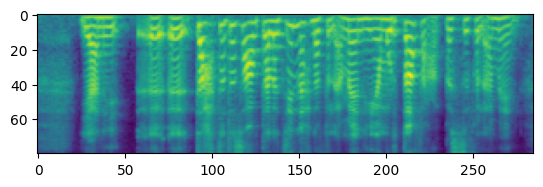

In [28]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

In [29]:
spectrogram = torch.tensor(processed_example["labels"])
with torch.no_grad():
    speech = vocoder(spectrogram)

In [30]:
from IPython.display import Audio
Audio(speech.cpu().numpy(), rate=16000)

In [31]:
dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names,)

Map:   0%|          | 0/1540 [00:00<?, ? examples/s]

In [32]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200

dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])

Filter:   0%|          | 0/1540 [00:00<?, ? examples/s]

In [33]:
dataset

Dataset({
    features: ['input_ids', 'labels', 'speaker_embeddings'],
    num_rows: 1446
})

## split data


In [34]:
dataset = dataset.train_test_split(test_size=0.1, seed=42)

## Collator

In [35]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:

        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        batch = processor.pad(
            input_ids=input_ids,
            labels=label_features,
            return_tensors="pt",
        )        

        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        del batch["decoder_attention_mask"]

        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor([
                len(feature["input_values"]) for feature in label_features
            ])
            target_lengths = target_lengths.new([
                length - length % model.config.reduction_factor for length in target_lengths
            ])
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In [36]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

In [37]:
features = [
    dataset["train"][0],
    dataset["train"][1],
    dataset["train"][20],
]

batch = data_collator(features)

In [38]:
{k:v.shape for k,v in batch.items()}

{'input_ids': torch.Size([3, 176]),
 'attention_mask': torch.Size([3, 176]),
 'labels': torch.Size([3, 938, 80]),
 'speaker_embeddings': torch.Size([3, 512])}

## Training

* Freeze encoder completely 
* LoRA on decoder transformer layers Train postnet normally

In [39]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

In [40]:
# Freeze layers
for p in model.speecht5.encoder.parameters():
    p.requires_grad = False

for p in model.speecht5.decoder.prenet.parameters():
    p.requires_grad = False

for p in model.speecht5.decoder.wrapped_decoder.parameters():
    p.requires_grad = True

for p in model.speech_decoder_postnet.parameters():
    p.requires_grad = True


In [41]:
model.config.use_cache = False

In [42]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    
    output_dir="microsoft/speecht5_tts_ar",
    per_device_train_batch_size=2,      
    gradient_accumulation_steps=4,      
    learning_rate=2e-5,               
    warmup_steps=800,
    num_train_epochs=5,                 
    gradient_checkpointing=True,
    fp16=True,
    eval_steps=200,
    save_steps=200,
    logging_steps=50,
    greater_is_better=False,
    report_to=["tensorboard"],
    push_to_hub=True                   
)

training_args._n_gpu = 1

In [43]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=Tokenizer
)

/tmp/ipykernel_1685/759589175.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [44]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss
50,1.304200
100,1.336000
150,1.233800
200,1.281400
250,1.267900
300,1.276300
350,1.264700
400,1.187300
450,1.188100
500,1.199600


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 1876}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


TrainOutput(global_step=815, training_loss=1.2053514468889295, metrics={'train_runtime': 329.3292, 'train_samples_per_second': 19.752, 'train_steps_per_second': 2.475, 'total_flos': 754935144650280.0, 'train_loss': 1.2053514468889295, 'epoch': 5.0})

# **Uploading Model & Processor to Hugging Face Hub**

In [47]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
HF_token = user_secrets.get_secret("tts")

In [48]:
from huggingface_hub import login
login(token=HF_token)

In [53]:
model.save_pretrained("microsoft/speecht5_tts_ar")
processor.save_pretrained("microsoft/speecht5_tts_ar")

from huggingface_hub import login, create_repo

model.push_to_hub("mohammedehab100/microsoft-speecht5_tts_ar", private=True, token=HF_token)
processor.push_to_hub("mohammedehab100/microsoft-speecht5_tts_ar", private=True, token=HF_token)

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/mohammedehab100/microsoft-speecht5_tts_ar/commit/2ca95767870f252bea3d25786fa663b8e6940068', commit_message='Upload processor', commit_description='', oid='2ca95767870f252bea3d25786fa663b8e6940068', pr_url=None, repo_url=RepoUrl('https://huggingface.co/mohammedehab100/microsoft-speecht5_tts_ar', endpoint='https://huggingface.co', repo_type='model', repo_id='mohammedehab100/microsoft-speecht5_tts_ar'), pr_revision=None, pr_num=None)

In [56]:
# Load model directly
from transformers import AutoProcessor, AutoModelForTextToSpectrogram

processor = AutoProcessor.from_pretrained("mohammedehab100/microsoft-speecht5_tts_ar")
model = AutoModelForTextToSpectrogram.from_pretrained("mohammedehab100/microsoft-speecht5_tts_ar")

preprocessor_config.json:   0%|          | 0.00/458 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/10.0k [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/696 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.05k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/578M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/195 [00:00<?, ?B/s]

In [59]:
from datasets import load_dataset
embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
speaker_embedding = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0)

In [67]:
text = "Good moring how are you , mohamed"
inputs = processor(text=text, return_tensors="pt")

speech = model.generate_speech(inputs["input_ids"], speaker_embedding, vocoder=vocoder)

Audio(speech, rate=16000)